In [1]:
import csv
from pathlib import Path
import logging as log
import itertools
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib import pyplot as plt

#plt.rcParams.update(params)

log.basicConfig(level=log.INFO)

all_data_path = Path('all-stats-summary.tsv')

In [2]:
def read_all(path):
    data = [[]]
    head = None
    with path.open() as p:
        for i, line in enumerate(p):
            #line = line.strip()
            if i == 0:
                head = line.split('\t')
                continue
            if not line.strip():
                # empty lines separate suit
                data.append([])
                continue
            rec = line.split('\t')
            if len(rec) != len(head):
                log.warning(f'skip: {line}')
                continue
            assert len(rec) == len(head)
            for i in range(1, len(rec)):
                if rec[i] == 'Chars':
                    rec[i] = "100"  # some placeholder
                cell = rec[i].replace(',', '').strip()
                rec[i] = float(cell) if cell else None
            data[-1].append(rec)
    return head, data
header, all_data = read_all(all_data_path)
print(len(all_data), sum(1 for grp in all_data for ex in grp))

11 106


# visualize  three axis plot

In [3]:
vocab_name = {
    'chars' : 'Char',
    '.5k.5k': '500',
    '01k01k': '1K',
    '02k02k': '2K',
    '04k04k': '4K',
    '08k08k': '8K', 
    '16k16k': '16K',
    '32k32k': '32K',    
    '48k48k': '48K',        
    '64k64k': '64K'    
}
name_name = {
    'deen-030k': r'DE$\rightarrow$EN 30K',
    'deen-500k': r'DE$\rightarrow$EN 0.5M',
    'deen-001m': r'DE$\rightarrow$EN 1M',
    'deen-all': r'DE$\rightarrow$EN 4.5M',
    'ende-030k': r'EN$\rightarrow$DE 30K',
    'ende-500k': r'EN$\rightarrow$DE 0.5M',
    'ende-001m': r'EN$\rightarrow$DE 1M',
    'ende-all': r'EN$\rightarrow$DE 4.5M',
    'enhi-500k': r'EN$\rightarrow$HI 0.5M',
    'enhi-all': r'EN$\rightarrow$HI 1.3M',
    'enlt-all': r'EN$\rightarrow$LT 0.6M',
}
sns.set(font="Times New Roman", style='white',font_scale=1.5)

In [4]:
header

['Experiment',
 'n:',
 'src_toks',
 'src_mean_len',
 'src_EMD',
 'src_effective_n',
 'src_f90p',
 'src_f95p',
 'src_f98p',
 'src_f99p',
 'src_f100p',
 'tgt_toks',
 'tgt_mean_len',
 'tgt_EMD',
 'tgt_effective_n',
 'tgt_f90p',
 'tgt_f95p',
 'tgt_f98p',
 'tgt_f99p',
 'tgt_f100p',
 'BLEU_dev',
 'prec_corr_dev',
 'recall_corr_dev',
 'BLEU_test',
 'prec_corr_test',
 'recall_corr_test\n']

saving to viz2/3axv-dev-deen-30k.pdf


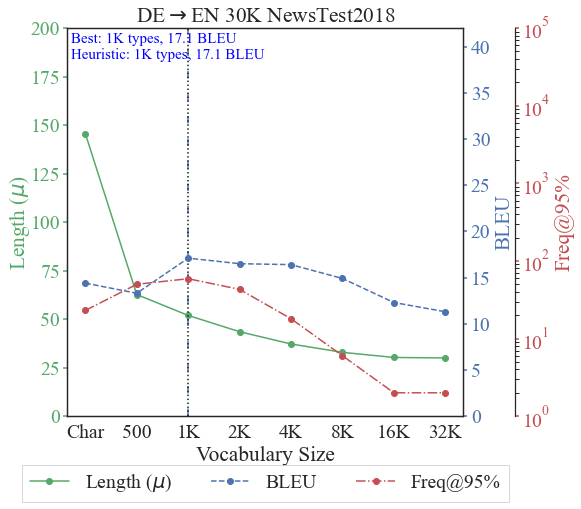

saving to viz2/3axv-dev-deen-0.5m.pdf


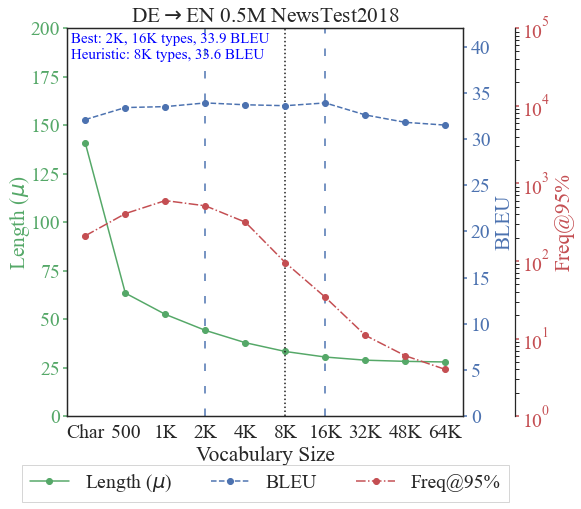

saving to viz2/3axv-dev-deen-1m.pdf


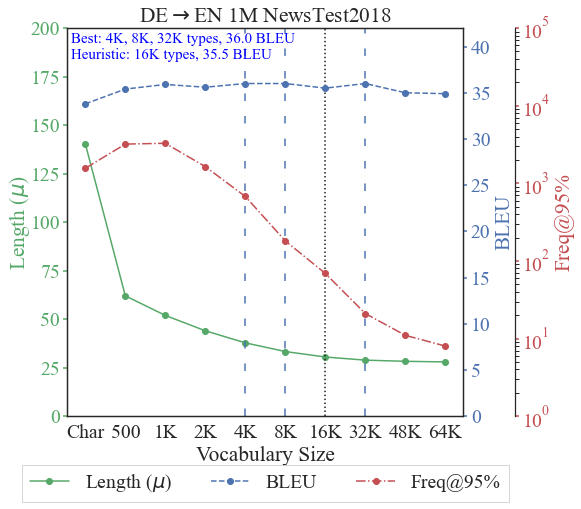

saving to viz2/3axv-dev-deen-4.5m.pdf


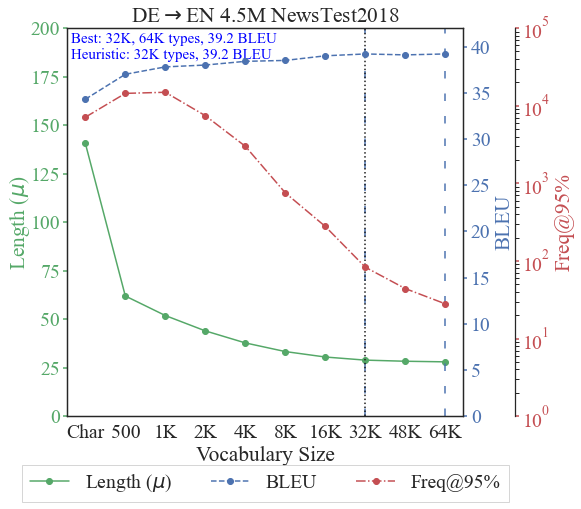

saving to viz2/3axv-dev-ende-30k.pdf


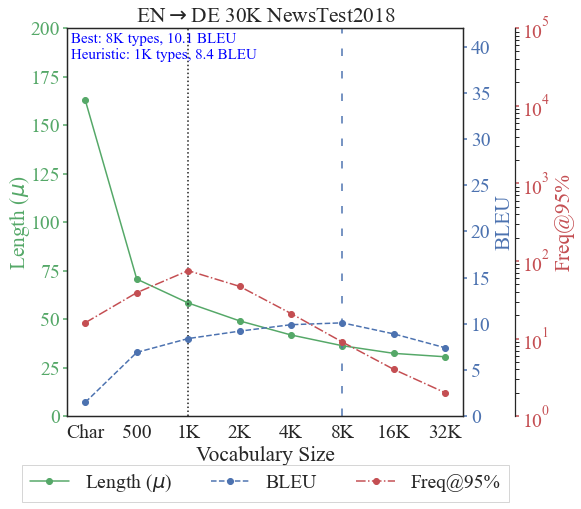

saving to viz2/3axv-dev-ende-0.5m.pdf


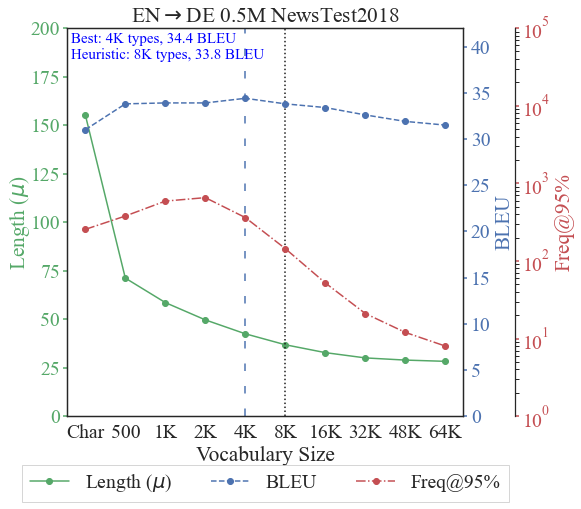

saving to viz2/3axv-dev-ende-1m.pdf


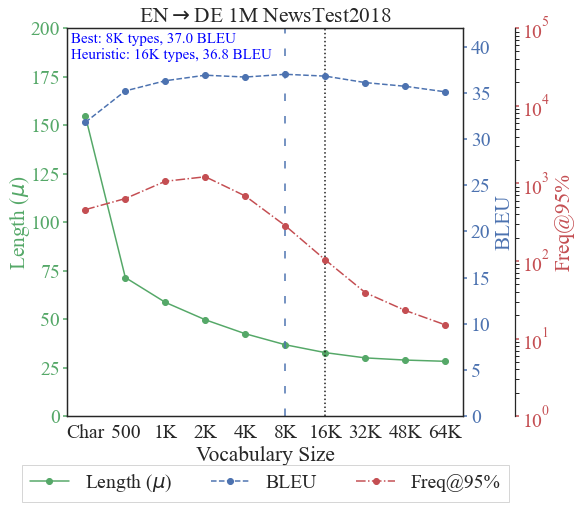

saving to viz2/3axv-dev-ende-4.5m.pdf


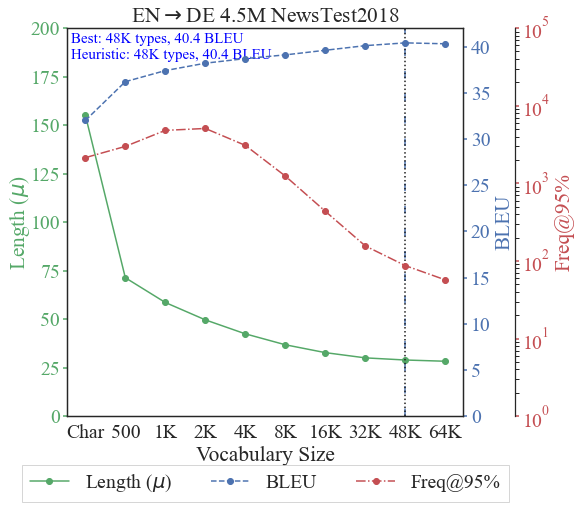

saving to viz2/3axv-dev-enhi-0.5m.pdf


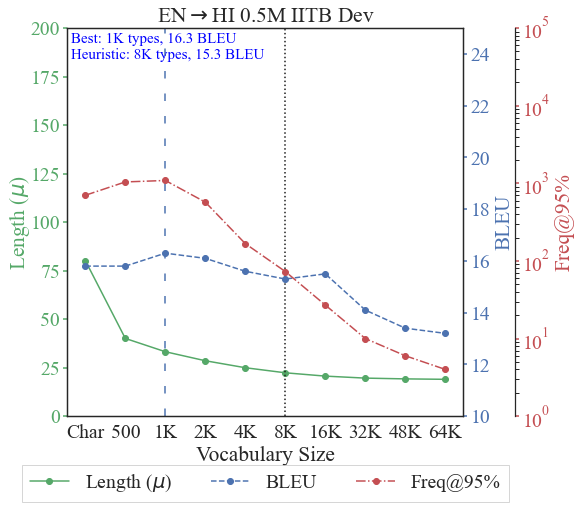

saving to viz2/3axv-dev-enhi-1.3m.pdf


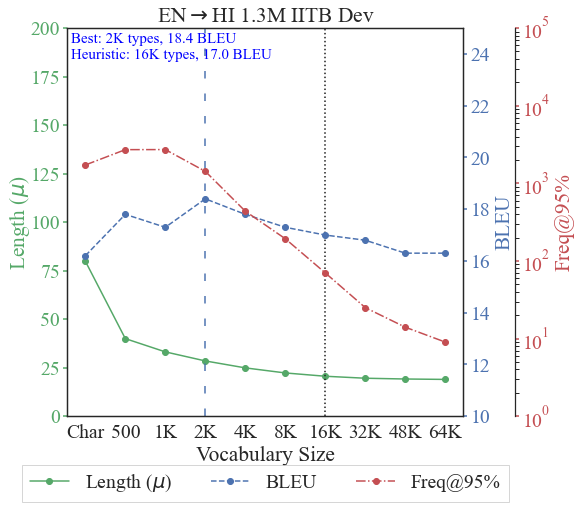

saving to viz2/3axv-dev-enlt-0.6m.pdf


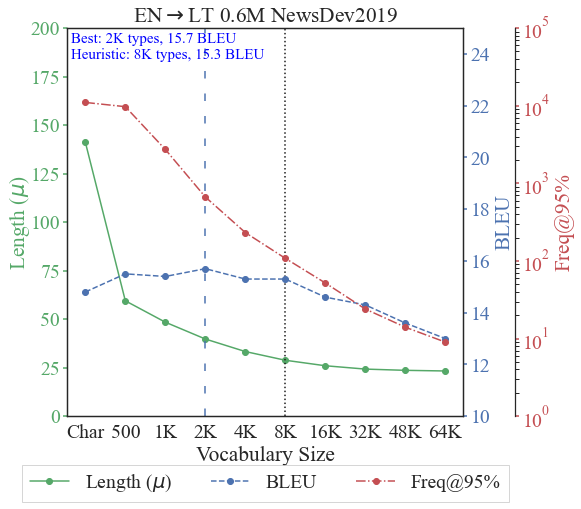

saving to viz2/3axv-test-deen-30k.pdf


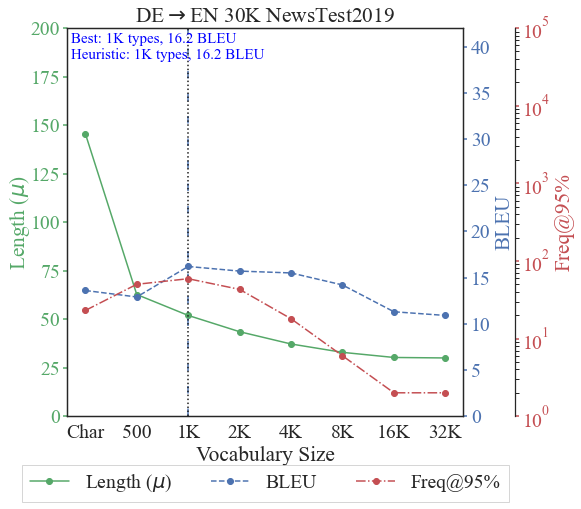

saving to viz2/3axv-test-deen-0.5m.pdf


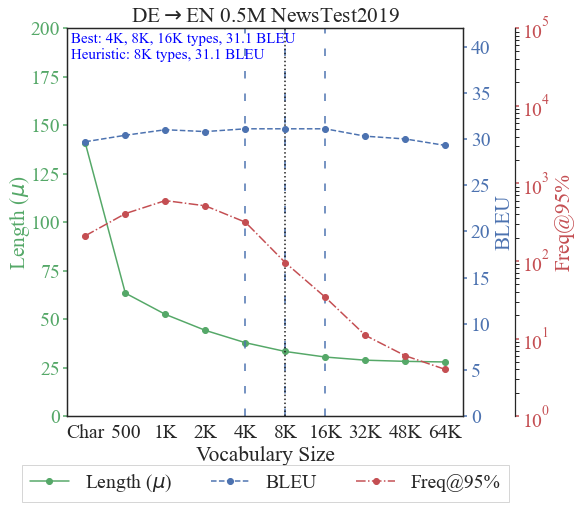

saving to viz2/3axv-test-deen-1m.pdf


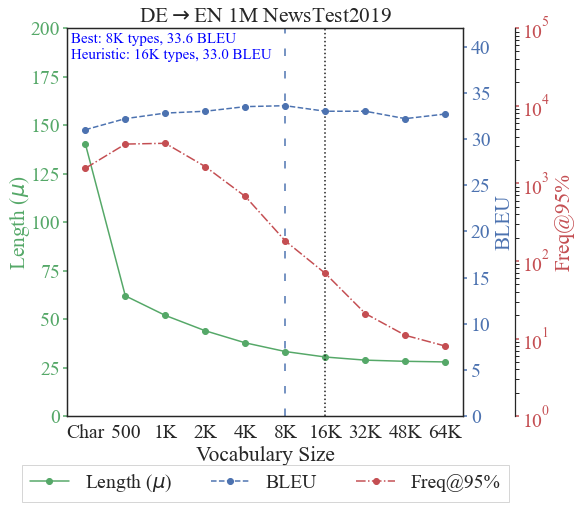

saving to viz2/3axv-test-deen-4.5m.pdf


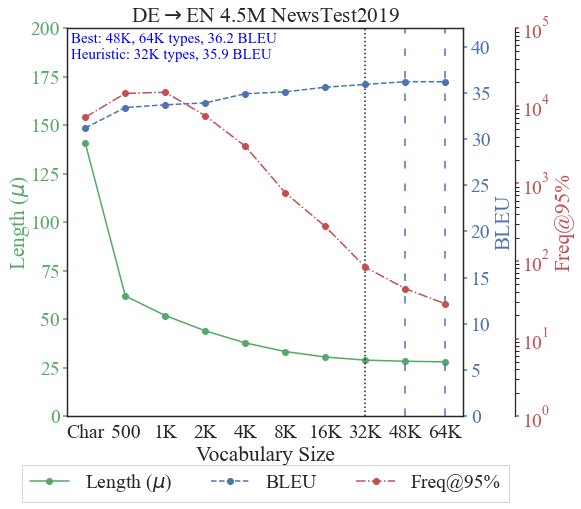

saving to viz2/3axv-test-ende-30k.pdf


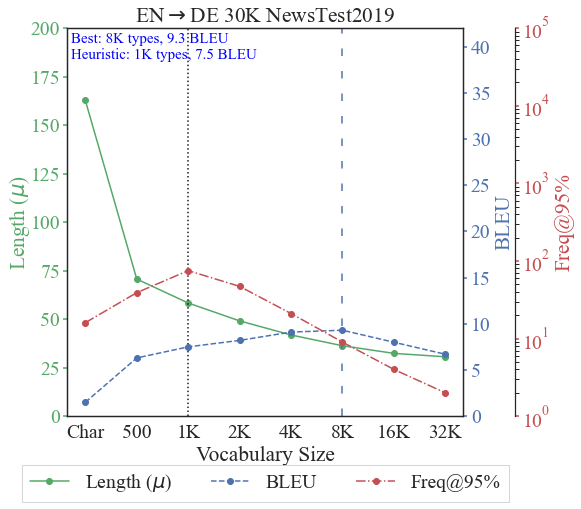

saving to viz2/3axv-test-ende-0.5m.pdf


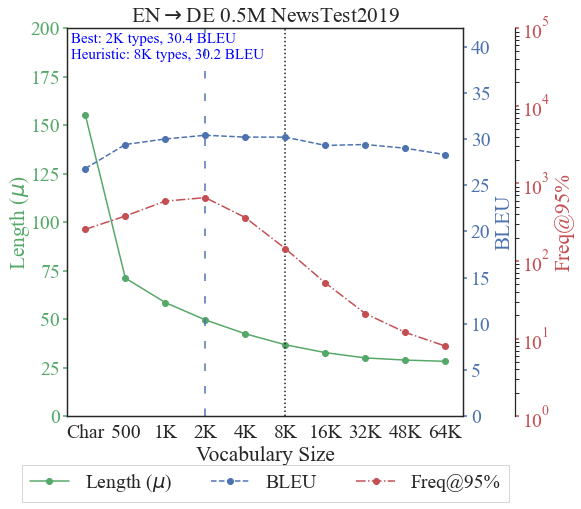

saving to viz2/3axv-test-ende-1m.pdf


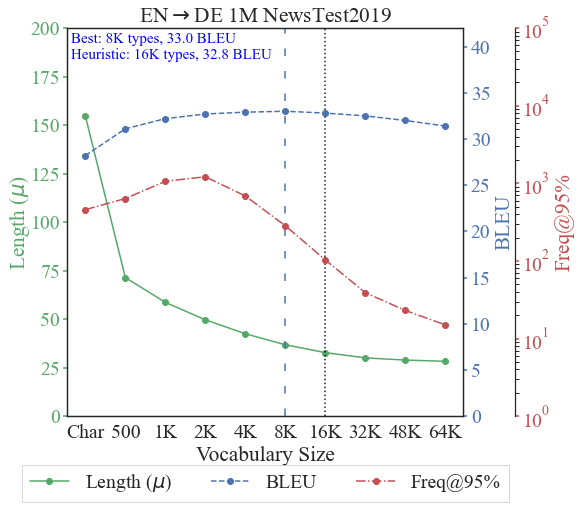

saving to viz2/3axv-test-ende-4.5m.pdf


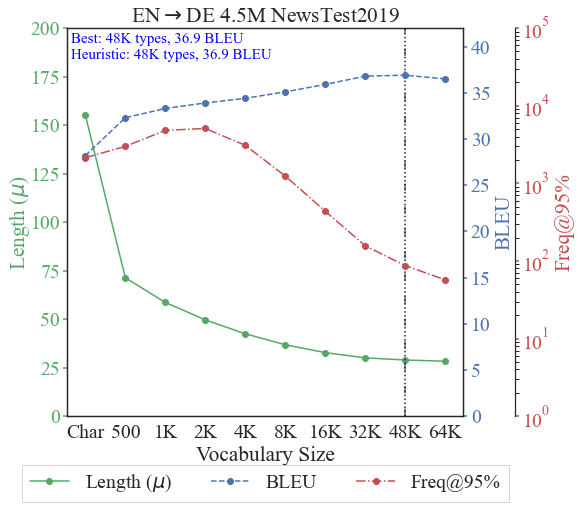

saving to viz2/3axv-test-enhi-0.5m.pdf


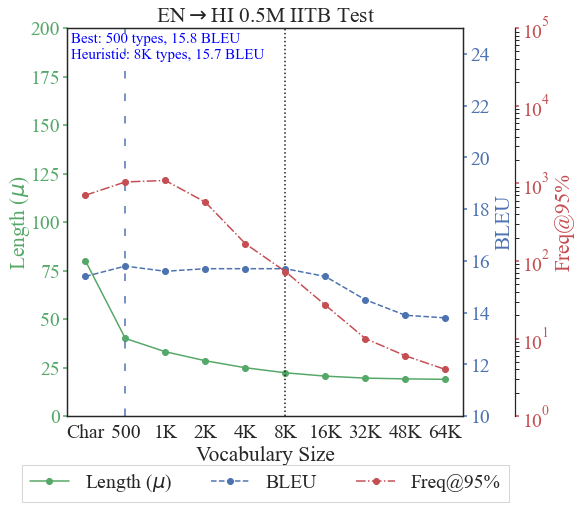

saving to viz2/3axv-test-enhi-1.3m.pdf


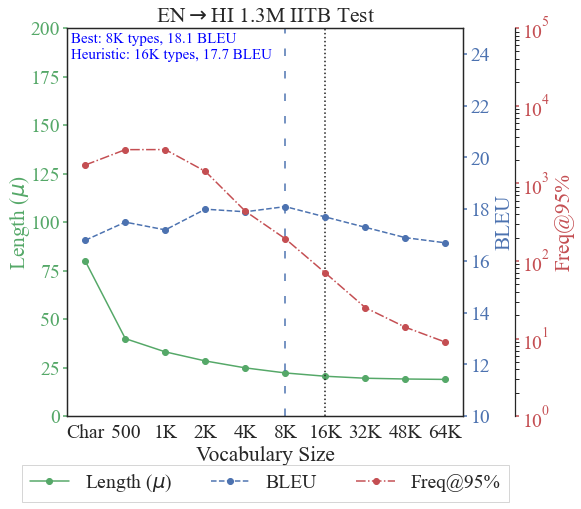

saving to viz2/3axv-test-enlt-0.6m.pdf


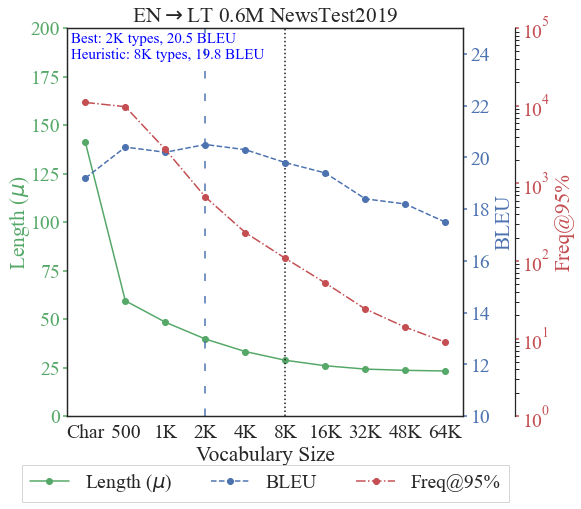

In [5]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

def three_axes_plot(x, y1, y2, y3, legends, y_maxs=None, title=None, subtitle=None, y_mins=None, save=None, 
                    figsize=(10, 7), scales=['linear', 'linear', 'linear', 'linear'],
                    max_bleu_lines=None,  heuristic_lines=None, adjust=None):
    assert len(legends) == 4 # [x, y1, y2, y3]

    fig, host = plt.subplots(figsize=figsize)
    fig.tight_layout()   
    fig.subplots_adjust(**adjust)

    par1 = host
    par2 = host.twinx()
    par3 = host.twinx()
    #par4 = host.twinx()

    # Offset the right spine of par3.  The ticks and label have already been
    # placed on the right by twinx above.
    par3.spines["right"].set_position(("axes", 1.13))
    # Having been created by twinx, par3 has its frame off, so the line of its
    # detached spine is invisible.  First, activate the frame but make the patch
    # and spines invisible.
    make_patch_spines_invisible(par3)
    # Second, show the right spine.
    par3.spines["right"].set_visible(True)
    
    # 4th axis
    #par4.spines["right"].set_position(("axes", -0.22))
    #make_patch_spines_invisible(par4)
    #par4.spines["right"].set_visible(True)

    p1, = par1.plot(x, y1, "g-o", label=legends[1])
    p2, = par2.plot(x, y2, "b--o", label=legends[2])
    p3, = par3.plot(x, y3, "r-.o", label=legends[3])
    #p4, = par4.plot(x, y4, "c:o", label=legends[4])    

    y_mins = y_mins or [0] * 3
    y_maxs = y_maxs or [max(line) * 1.1 for line in [y1, y2, y3]]
    assert len(y_maxs) == 3    
    assert len(y_mins) == 3 
    par1.set_ylim(y_mins[0], y_maxs[0])
    par2.set_ylim(y_mins[1], y_maxs[1])
    par3.set_ylim(y_mins[2], y_maxs[2])
    #par4.set_ylim(y_mins[3], y_maxs[3])    

    par1.set_xlabel(legends[0])
    par1.set_ylabel(legends[1], labelpad=-2)
    par2.set_ylabel(legends[2])
    par3.set_ylabel(legends[3])
    #par4.set_ylabel(legends[4], labelpad=-60)    

    par1.yaxis.label.set_color(p1.get_color())
    par2.yaxis.label.set_color(p2.get_color())
    par3.yaxis.label.set_color(p3.get_color())
    #par4.yaxis.label.set_color(p4.get_color())

    assert len(scales) == 3
    for par, yscale in zip([par1, par2, par3], scales):
        par.set_yscale(yscale)

    tkw = dict(size=4, width=1.5)
    par1.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par2.tick_params(axis='y', colors=p2.get_color(), **tkw)
    par3.tick_params(axis='y', colors=p3.get_color(), **tkw)
    #par4.tick_params(axis='y', colors=p4.get_color(), **tkw)    
    host.tick_params(axis='x', **tkw)

    lines = [p1, p2, p3]
    if max_bleu_lines:
        for line in max_bleu_lines:
            par1.axvline(x=line, c='b', linestyle=(0, (5, 10)))
    if heuristic_lines:
        for line in heuristic_lines:
            par1.axvline(x=line, c='k', linestyle=':')

    host.legend(lines, [l.get_label() for l in lines], loc='upper center', ncol=4, 
                fancybox=False, bbox_to_anchor=(0.5,-0.1))


    if title:
        plt.title(title)
    if subtitle:
        par1.text(0.01, 0.99, subtitle,
            verticalalignment='top', horizontalalignment='left',
            transform=par1.transAxes,
            color='blue', fontsize=15)
    if save:
        print(f'saving to {save}')
        plt.savefig(save)
    plt.show()
    

def to_3ax_data(head, data, x, y1, y2, y3):
    x_idx = head.index(x)
    y1_idx = head.index(y1)
    y2_idx = head.index(y2)
    y3_idx = head.index(y3)
    #y4_idx = head.index(y4)    
    res = []
    for grp in data:
        buf = np.zeros((len(grp), 3), dtype=np.float)
        xs = [None] * len(grp)
        grp_name = None
        for i, ex in enumerate(grp):
            x = ex[x_idx]
            grp_name, x_name = x.split('/')
            xs[i] = x_name.split('-')[2]
            grp_name = grp_name.replace('runs-', '')
            buf[i, 0] = ex[y1_idx]
            buf[i, 1]= ex[y2_idx]
            buf[i, 2]= ex[y3_idx]
            #buf[i, 3]= ex[y4_idx]
        res.append((grp_name, xs, buf))
    return res
    

sns.set(font="Times New Roman", style='white', font_scale=1.78)

def heuristic_select(freqs, threshold=100):
    """Heuristic used to select best vocab, based on freq@95% """
    # assumption frequences are sorted as increasing order of vocab size
    # traverse from right side i.e max vocab
    for i in range(len(freqs)-1, -1, -1):
        freq = freqs[i]
        if freq >= threshold:
            high = freq
            if i < len(freqs):
                low = freqs[i+1]
                # find nearest
                if abs(low - threshold) < abs(high - threshold):
                    return i+1
            return i
    # if all freqs are lower than threshold, return whatever max was found
    return np.argmax(freqs)

for split in ['dev', 'test']:
    fields = dict(y1='tgt_mean_len', y2=f'BLEU_{split}', y3='tgt_f95p', x='Experiment')
    data_3ax = to_3ax_data(header, all_data, **fields)
    legends = ['Vocabulary Size'] + [r'Length ($\mu$)', 'BLEU', 'Freq@95%']
    c = 0
    for name, xs, ys in data_3ax:
        xs = [vocab_name[x] for x in xs]
        name = name_name[name]
        y_mu, y_bleu, y_f = ys[:,0], ys[:,1], ys[:,2]
        scales = ['linear', 'linear', 'log']
        max_bleu, min_bleu = max(y_bleu), min(y_bleu)
        
        #max_bleu = 10 * math.ceil(max_bleu/10)
        set_name = ''
        if 'DE' in name:
            min_bleu, max_bleu = 0, 42
            set_name = 'NewsTest2018' if split == 'dev' else 'NewsTest2019'
        else:
            min_bleu, max_bleu = 10, 25
            if 'HI' in name:
                set_name = 'IITB Dev' if split == 'dev' else 'IITB Test'
            else:
                assert 'LT' in name
                set_name = 'NewsDev2019' if split == 'dev' else 'NewsTest2019'
        min_bleu = 10 * math.floor(min_bleu/10)

        y_maxs = [200, max_bleu, 10 ** 5 ]
        y_mins = [0,   min_bleu, 1]

        save_to = f'viz2/3axv-{split}-'
        save_to += name.replace(r'$\rightarrow$', '').replace(' ', '-').lower() + '.pdf'
        name = f'{name} {set_name}'
        #save_to = None
        adjust=dict(bottom=0.17, left=0.25, top=0.94, right=0.8)
        

        max_bleu_lines = [i for i, v in enumerate(y_bleu) if abs(max(y_bleu) - v) <= 0.1]
        heur_idx = heuristic_select(y_f)
        best_vocabs = ", ".join(xs[i] for i in max_bleu_lines)
        
        subtitle = f'Best: {best_vocabs} types, {max(y_bleu)} BLEU\nHeuristic: {xs[heur_idx]} types, {y_bleu[heur_idx]:.1f} BLEU'
        three_axes_plot(x=xs, y1=y_mu, y2=y_bleu, y3=y_f, title=name,
                        subtitle=subtitle,
                        legends=legends, y_maxs=y_maxs, y_mins=y_mins, scales=scales, 
                        save=save_to, adjust=adjust,
                        max_bleu_lines=max_bleu_lines,
                        heuristic_lines = [heur_idx])
        c += 1
        if c >= 1:
            #break
            pass

[2, 3, 4, 5, 6, 7]